### In the notebook below I reduced features by keeping only this with a correlation above 0.2, as the negative correlations were low and so there was likely little loss from cutting these from our feature set.

### I then built an initial model, ran Linear Regression, Lasso and Ridge, all of which were very close. I then added categorical variables using those that correlated well to price from an initial group of scatter plots, keeping those that improved the test score. I also removed low coefficient values, removed collinear features and removed outliers which helped me arrive at my final feature set and I found Lasso to be the highest scoring model.

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso, Ridge

In [4]:
df = pd.read_csv('clean_Ames_data.csv')

#### Let's start by looks at feature correlations to price for the numerical variables. Certain variables correlate extremely well (quality, living area) and tend to relate to size and square footage. 

In [5]:
df.corr()['SalePrice'].sort_values()

PID               -0.255052
Enclosed Porch    -0.135656
Kitchen AbvGr     -0.125444
Overall Cond      -0.097019
MS SubClass       -0.087335
Id                -0.051398
Bsmt Half Bath    -0.045290
Low Qual Fin SF   -0.041594
Yr Sold           -0.015203
Misc Val          -0.007375
BsmtFin SF 2       0.016432
Pool Area          0.023106
Unnamed: 0         0.027789
Mo Sold            0.032735
3Ssn Porch         0.048732
Screen Porch       0.134581
Bedroom AbvGr      0.137067
Lot Frontage       0.181456
Bsmt Unf SF        0.190861
2nd Flr SF         0.248452
Half Bath          0.283001
Bsmt Full Bath     0.283332
Lot Area           0.296566
Wood Deck SF       0.326490
Open Porch SF      0.333476
BsmtFin SF 1       0.423856
Fireplaces         0.471093
Mas Vnr Area       0.503579
TotRms AbvGrd      0.504014
Garage Yr Blt      0.516738
Full Bath          0.537969
Year Remod/Add     0.550370
Year Built         0.571849
1st Flr SF         0.618486
Total Bsmt SF      0.629303
Garage Cars        0

#### We will start with our initial model by reducing our features to those with correlations to Sale Price above 0.2.

In [6]:
features = ['Bsmt Unf SF', '2nd Flr SF', 'Half Bath', 'Bsmt Full Bath', 'Wood Deck SF', 'Open Porch SF',
            'BsmtFin SF 1', 'Fireplaces', 'Mas Vnr Area',
           'TotRms AbvGrd', 'Garage Yr Blt', 'Full Bath', 'Year Remod/Add', 'Year Built', '1st Flr SF', 'Total Bsmt SF',
           'Garage Cars', 'Garage Area', 'Gr Liv Area', 'Overall Qual']

X = df[features]
y = df['SalePrice']

#### We split the data using 25% for test set. This is reasonable since the dataset is fairly large and should give us sufficient training data, while providing enough test data given the model has a large number of features and we want to prevent overfitting.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25)

In [8]:
#Scaling our data since the scales are so variable across the features
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

#### We will use Linear regression, Lasso and Ridge and will use 5 fold cross validation for a more reliable, less overfit score. We will also take root mean squared error as an additional error metric.

In [9]:
lr = LinearRegression()

lasso = Lasso()

ridge = Ridge()

In [10]:
lr.fit(X_train, y_train)
predictions = lr.predict(X_train)
rmse = (mean_squared_error(y_train, predictions)**0.5)

print(f'Training score: {lr.score(X_train, y_train)}, Test score: {lr.score(X_test, y_test)}, RMSE: {rmse}')

Training score: 0.797042457471709, Test score: 0.8512363315540015, RMSE: 35827.49060274978


In [11]:
cross_val_score (lr, X_train, y_train, cv = 5).mean()

0.7644212996045437

In [12]:
lasso.fit(X_train, y_train)
predictions = lasso.predict(X_train)
rmse = (mean_squared_error(y_train, predictions)**0.5)

print(f'Training score: {lasso.score(X_train, y_train)}, Test score: {lasso.score(X_test, y_test)}, RMSE: {rmse}')

Training score: 0.7970424473223421, Test score: 0.85123062550987, RMSE: 35827.49149856853


In [13]:
cross_val_score (lasso, X_train, y_train, cv = 5).mean()

/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.129e+09, tolerance: 7.607e+08
  model = cd_fast.enet_coordinate_descent(


0.7644553272987855

In [14]:
ridge.fit(X_train, y_train)
predictions = ridge.predict(X_train)
rmse = (mean_squared_error(y_train, predictions)**0.5)

print(f'Training score: {ridge.score(X_train, y_train)}, Test score: {ridge.score(X_test, y_test)}, RMSE: {rmse}')

Training score: 0.7970422586360166, Test score: 0.8512463406228401, RMSE: 35827.50815268181


In [15]:
cross_val_score (ridge, X_train, y_train, cv = 5).mean()

0.7646704308354807

#### The models initially seem underfit and there is little difference between the scores. On cross validation, the scores are 0.76, though this is actually materially affected by the random seed. Also, the RMSE are extremely similar between models.

#### Let's try and improve on this through feature engineering. We will start by using get_dummies across categorical variables. I first looked at scatter charts of categoricals vs Sale Price to understand which ones likely have value to the model. 

In [16]:
df_2 = df[['MS SubClass', 'MS Zoning', 'Lot Shape', 'Neighborhood', 
          'Condition 1', 'Bldg Type', 'House Style', 'Exter Qual', 'Exter Cond',
          'BsmtFin Type 1', 'Garage Type']]

In [17]:
df_3 = df[['Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
          'Bsmt Cond', 'Heating QC', 'Central Air', 'Pool QC']]

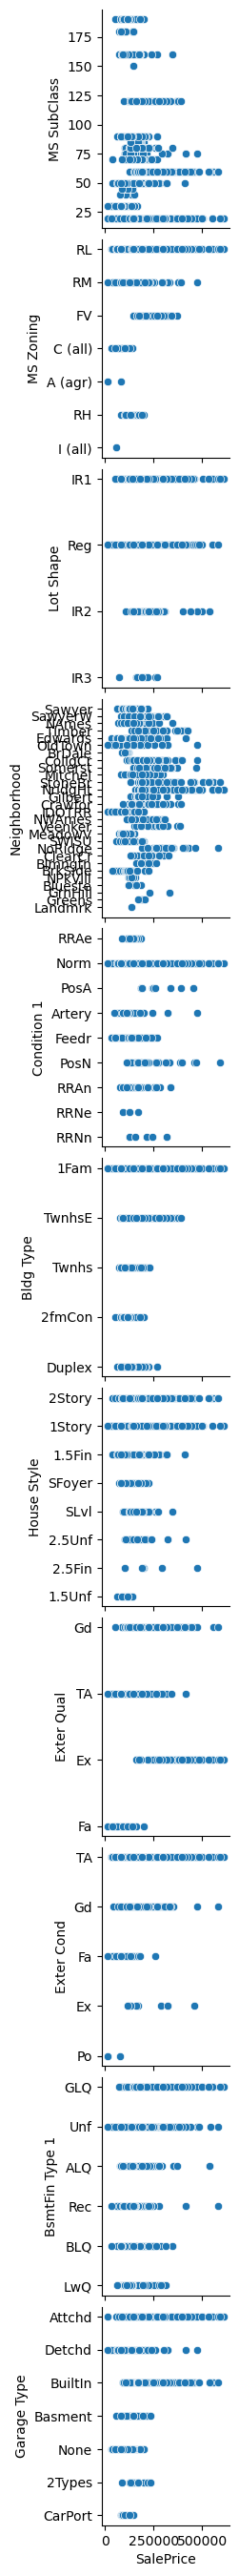

In [18]:
sns.pairplot(df, y_vars = ['MS SubClass', 'MS Zoning', 'Lot Shape', 'Neighborhood', 
          'Condition 1', 'Bldg Type', 'House Style', 'Exter Qual', 'Exter Cond',
          'BsmtFin Type 1', 'Garage Type'], x_vars = ['SalePrice'])

In [19]:
sns.pairplot(df, y_vars = ['Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
          'Bsmt Cond', 'Heating QC', 'Central Air', 'Pool QC'], x_vars = ['SalePrice'])


#### From our first pass, it looks like neighborhood, subclass, house style, exterior quality, garage type, roof style, exterior 1st (exterior covering), masonry veneer type, heating quality and central heating correlate well to Sale Price. 

#### For each feature we will dummify, add to the feature set and then see if this improves our model. If so we will keep, if not we will remove. We will be using LR to test each feature as there were negligible differences between the models on a first pass and then we will try Lasso and Ridge on the final model

#### Adding Neighborhood

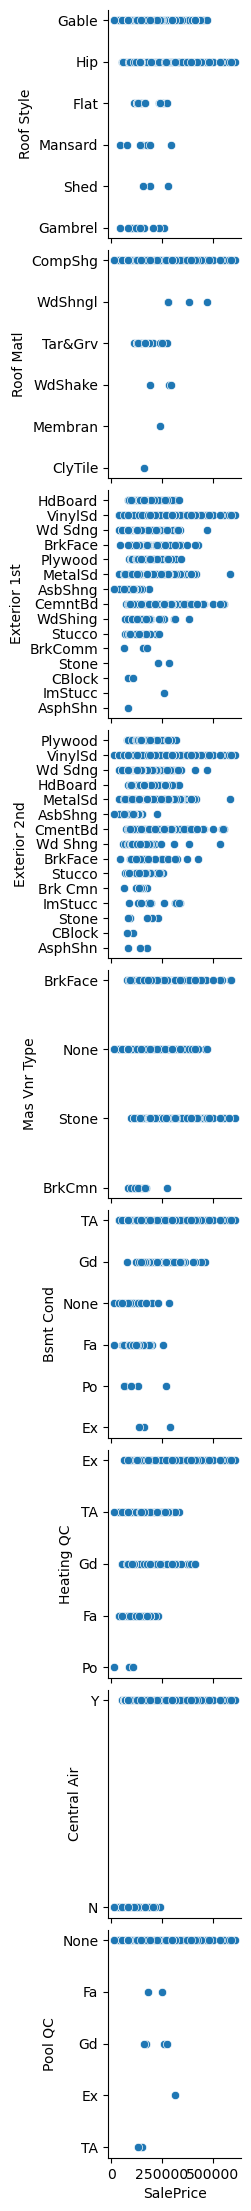

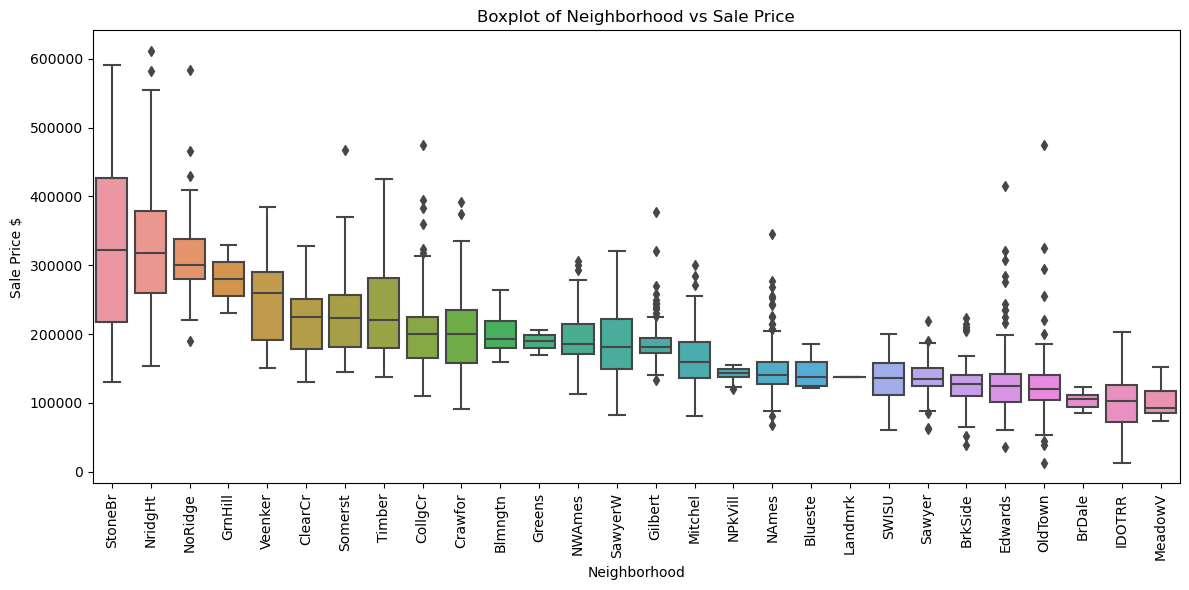

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6)) 

order = df.groupby('Neighborhood')['SalePrice'].median().sort_values(ascending=False).index

sns.boxplot(x='Neighborhood', y='SalePrice', data=df, order=order)

plt.title('Boxplot of Neighborhood vs Sale Price')
plt.xlabel('Neighborhood')
plt.ylabel('Sale Price $')

plt.xticks(rotation=90)

plt.tight_layout()
plt.savefig('neighborhood.png')
plt.show()


In [21]:
# Adding Neighborhood
neighborhood = pd.get_dummies(df['Neighborhood'], drop_first = True)
neighborhood

,Blueste,BrDale,BrkSide,ClearCr,CollgCr,Crawfor,Edwards,Gilbert,Greens,GrnHill,...,NoRidge,NridgHt,OldTown,SWISU,Sawyer,SawyerW,Somerst,StoneBr,Timber,Veenker
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2047,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2048,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2049,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
#Building a function to add feature name when doing get_dummies

def add_name(df, name):
    col_list = []
    col_list_new = []
    for col in df.columns:
        col_list.append(col)
    for col in col_list:
        title = f'{col}_{name}'
        col_list_new.append(title)

    count = 0
    for col in df.columns:
        df = df.rename(columns = {col: col_list_new[count]})
        count +=1
    return df

In [23]:
neighborhood = add_name(neighborhood, 'neigh')


In [24]:
neighborhood

,Blueste_neigh,BrDale_neigh,BrkSide_neigh,ClearCr_neigh,CollgCr_neigh,Crawfor_neigh,Edwards_neigh,Gilbert_neigh,Greens_neigh,GrnHill_neigh,...,NoRidge_neigh,NridgHt_neigh,OldTown_neigh,SWISU_neigh,Sawyer_neigh,SawyerW_neigh,Somerst_neigh,StoneBr_neigh,Timber_neigh,Veenker_neigh
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2047,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2048,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2049,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
orig_features_and_price = ['Bsmt Unf SF', '2nd Flr SF', 'Half Bath', 'Bsmt Full Bath', 'Wood Deck SF', 'Open Porch SF',
            'BsmtFin SF 1', 'Fireplaces', 'Mas Vnr Area',
           'TotRms AbvGrd', 'Garage Yr Blt', 'Full Bath', 'Year Remod/Add', 'Year Built', '1st Flr SF', 'Total Bsmt SF',
           'Garage Cars', 'Garage Area', 'Gr Liv Area', 'Overall Qual', 'SalePrice']

df_model = df[orig_features_and_price]
df_model.head()

,Bsmt Unf SF,2nd Flr SF,Half Bath,Bsmt Full Bath,Wood Deck SF,Open Porch SF,BsmtFin SF 1,Fireplaces,Mas Vnr Area,TotRms AbvGrd,...,Full Bath,Year Remod/Add,Year Built,1st Flr SF,Total Bsmt SF,Garage Cars,Garage Area,Gr Liv Area,Overall Qual,SalePrice
0,192.0,754,1,0.0,0,44,533.0,0,289.0,6,...,2,2005,1976,725,725.0,2.0,475.0,1479,6,130500
1,276.0,1209,1,1.0,0,74,637.0,1,132.0,8,...,2,1997,1996,913,913.0,2.0,559.0,2122,7,220000
2,326.0,0,0,1.0,0,52,731.0,0,0.0,5,...,1,2007,1953,1057,1057.0,1.0,246.0,1057,5,109000
3,384.0,700,1,0.0,100,0,0.0,0,0.0,7,...,2,2007,2006,744,384.0,2.0,400.0,1444,5,174000
4,676.0,614,0,0.0,0,59,0.0,0,0.0,6,...,2,1993,1900,831,676.0,2.0,484.0,1445,6,138500


In [26]:
df_model = df_model.join(neighborhood)

In [27]:
df_model.head()

,Bsmt Unf SF,2nd Flr SF,Half Bath,Bsmt Full Bath,Wood Deck SF,Open Porch SF,BsmtFin SF 1,Fireplaces,Mas Vnr Area,TotRms AbvGrd,...,NoRidge_neigh,NridgHt_neigh,OldTown_neigh,SWISU_neigh,Sawyer_neigh,SawyerW_neigh,Somerst_neigh,StoneBr_neigh,Timber_neigh,Veenker_neigh
0,192.0,754,1,0.0,0,44,533.0,0,289.0,6,...,0,0,0,0,1,0,0,0,0,0
1,276.0,1209,1,1.0,0,74,637.0,1,132.0,8,...,0,0,0,0,0,1,0,0,0,0
2,326.0,0,0,1.0,0,52,731.0,0,0.0,5,...,0,0,0,0,0,0,0,0,0,0
3,384.0,700,1,0.0,100,0,0.0,0,0.0,7,...,0,0,0,0,0,0,0,0,1,0
4,676.0,614,0,0.0,0,59,0.0,0,0.0,6,...,0,0,0,0,0,1,0,0,0,0


In [28]:
X = df_model.drop(columns = 'SalePrice')
y = df_model['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25)

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

lr = LinearRegression()

In [29]:
lr.fit(X_train, y_train)
predictions = lr.predict(X_train)
rmse = (mean_squared_error(y_train, predictions)**0.5)

print(f'Train score: {lr.score(X_train, y_train)}, Test score: {lr.score(X_test, y_test)}, RMSE: {rmse}')

Train score: 0.837999685322365, Test score: 0.8576412176240267, RMSE: 32008.971662915832


#### Adding Subclass

In [30]:
sns.boxplot(x = df['MS SubClass'], y = df['SalePrice'])

<AxesSubplot:xlabel='MS SubClass', ylabel='SalePrice'>

In [31]:
subclass = pd.get_dummies(df['MS SubClass'], drop_first = True)
subclass = add_name(subclass, 'subclass')

In [32]:
df_model1 = df_model.join(subclass)
df_model1

,Bsmt Unf SF,2nd Flr SF,Half Bath,Bsmt Full Bath,Wood Deck SF,Open Porch SF,BsmtFin SF 1,Fireplaces,Mas Vnr Area,TotRms AbvGrd,...,70_subclass,75_subclass,80_subclass,85_subclass,90_subclass,120_subclass,150_subclass,160_subclass,180_subclass,190_subclass
0,192.0,754,1,0.0,0,44,533.0,0,289.0,6,...,0,0,0,0,0,0,0,0,0,0
1,276.0,1209,1,1.0,0,74,637.0,1,132.0,8,...,0,0,0,0,0,0,0,0,0,0
2,326.0,0,0,1.0,0,52,731.0,0,0.0,5,...,0,0,0,0,0,0,0,0,0,0
3,384.0,700,1,0.0,100,0,0.0,0,0.0,7,...,0,0,0,0,0,0,0,0,0,0
4,676.0,614,0,0.0,0,59,0.0,0,0.0,6,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,873.0,0,0,1.0,0,276,1011.0,1,0.0,7,...,0,0,0,0,0,0,0,0,0,0
2047,599.0,0,0,0.0,158,0,262.0,0,0.0,4,...,0,0,0,0,0,0,0,0,0,0
2048,896.0,741,1,0.0,0,0,0.0,1,0.0,9,...,0,0,0,0,0,0,0,0,0,0
2049,295.0,0,0,1.0,0,189,155.0,2,0.0,6,...,0,0,0,0,0,0,0,0,0,0


In [33]:
X = df_model1.drop(columns = 'SalePrice')
y = df_model1['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25)

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

lr = LinearRegression()

In [34]:
lr.fit(X_train, y_train)
predictions = lr.predict(X_train)
rmse = (mean_squared_error(y_train, predictions)**0.5)

print(f'Train score: {lr.score(X_train, y_train)}, Test score: {lr.score(X_test, y_test)}, RMSE: {rmse}')

Train score: 0.853395191594476, Test score: 0.8741967795227209, RMSE: 30450.04230043766


#### This feature improved our model and improved our test score  along with reducing RMSE by ~$1500, so we will keep it.

#### House Style

In [35]:
sns.boxplot(x = df['House Style'], y = df['SalePrice'])

<AxesSubplot:xlabel='House Style', ylabel='SalePrice'>

In [36]:
house_style = pd.get_dummies(df['House Style'], drop_first = True)
house_style = add_name(house_style, 'h_style')

In [37]:
df_model2 = df_model1.join(house_style)
df_model2.head()

,Bsmt Unf SF,2nd Flr SF,Half Bath,Bsmt Full Bath,Wood Deck SF,Open Porch SF,BsmtFin SF 1,Fireplaces,Mas Vnr Area,TotRms AbvGrd,...,160_subclass,180_subclass,190_subclass,1.5Unf_h_style,1Story_h_style,2.5Fin_h_style,2.5Unf_h_style,2Story_h_style,SFoyer_h_style,SLvl_h_style
0,192.0,754,1,0.0,0,44,533.0,0,289.0,6,...,0,0,0,0,0,0,0,1,0,0
1,276.0,1209,1,1.0,0,74,637.0,1,132.0,8,...,0,0,0,0,0,0,0,1,0,0
2,326.0,0,0,1.0,0,52,731.0,0,0.0,5,...,0,0,0,0,1,0,0,0,0,0
3,384.0,700,1,0.0,100,0,0.0,0,0.0,7,...,0,0,0,0,0,0,0,1,0,0
4,676.0,614,0,0.0,0,59,0.0,0,0.0,6,...,0,0,0,0,0,0,0,0,0,0


In [38]:
X = df_model2.drop(columns = 'SalePrice')
y = df_model2['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25)

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

lr = LinearRegression()

In [39]:
lr.fit(X_train, y_train)
predictions = lr.predict(X_train)
rmse = (mean_squared_error(y_train, predictions)**0.5)

print(f'Train score: {lr.score(X_train, y_train)}, Test score: {lr.score(X_test, y_test)}, RMSE: {rmse}')

Train score: 0.8551838794952388, Test score: 0.8637019985950123, RMSE: 30263.715622684842


#### House Style resulted in a slightly worse model, so we will drop it.

#### Exterior Quality

In [40]:
sns.boxplot(x = df['Exter Qual'], y = df['SalePrice'])

<AxesSubplot:xlabel='Exter Qual', ylabel='SalePrice'>

In [41]:
exter_qual = pd.get_dummies(df['Exter Qual'], drop_first = True)
exter_qual = add_name(exter_qual, 'exter_qual')
exter_qual

,Fa_exter_qual,Gd_exter_qual,TA_exter_qual
0,0,1,0
1,0,1,0
2,0,0,1
3,0,0,1
4,0,0,1
...,...,...,...
2046,0,1,0
2047,0,0,1
2048,0,0,1
2049,0,0,1


In [42]:
df_model2 = df_model1.join(exter_qual)
df_model2.head()

,Bsmt Unf SF,2nd Flr SF,Half Bath,Bsmt Full Bath,Wood Deck SF,Open Porch SF,BsmtFin SF 1,Fireplaces,Mas Vnr Area,TotRms AbvGrd,...,85_subclass,90_subclass,120_subclass,150_subclass,160_subclass,180_subclass,190_subclass,Fa_exter_qual,Gd_exter_qual,TA_exter_qual
0,192.0,754,1,0.0,0,44,533.0,0,289.0,6,...,0,0,0,0,0,0,0,0,1,0
1,276.0,1209,1,1.0,0,74,637.0,1,132.0,8,...,0,0,0,0,0,0,0,0,1,0
2,326.0,0,0,1.0,0,52,731.0,0,0.0,5,...,0,0,0,0,0,0,0,0,0,1
3,384.0,700,1,0.0,100,0,0.0,0,0.0,7,...,0,0,0,0,0,0,0,0,0,1
4,676.0,614,0,0.0,0,59,0.0,0,0.0,6,...,0,0,0,0,0,0,0,0,0,1


In [43]:
X = df_model2.drop(columns = 'SalePrice')
y = df_model2['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25)

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

lr = LinearRegression()

In [44]:
lr.fit(X_train, y_train)
predictions = lr.predict(X_train)
rmse = (mean_squared_error(y_train, predictions)**0.5)

print(f'Train score: {lr.score(X_train, y_train)}, Test score: {lr.score(X_test, y_test)}, RMSE: {rmse}')

Train score: 0.8666547696527553, Test score: 0.8762992915377948, RMSE: 29040.39611421965


#### This is quite a decent improvement, so we will add it to the model

#### Garage Type

In [45]:
sns.boxplot(x = df['Garage Type'], y = df['SalePrice'])

<AxesSubplot:xlabel='Garage Type', ylabel='SalePrice'>

In [46]:
gar_type = pd.get_dummies(df['Garage Type'], drop_first = True)
gar_type = add_name(gar_type, 'gar_type')
gar_type

,Attchd_gar_type,Basment_gar_type,BuiltIn_gar_type,CarPort_gar_type,Detchd_gar_type,None_gar_type
0,1,0,0,0,0,0
1,1,0,0,0,0,0
2,0,0,0,0,1,0
3,0,0,1,0,0,0
4,0,0,0,0,1,0
...,...,...,...,...,...,...
2046,1,0,0,0,0,0
2047,0,0,0,0,1,0
2048,0,0,0,0,1,0
2049,1,0,0,0,0,0


In [47]:
df_model3 = df_model2.join(gar_type)
df_model3.head()

,Bsmt Unf SF,2nd Flr SF,Half Bath,Bsmt Full Bath,Wood Deck SF,Open Porch SF,BsmtFin SF 1,Fireplaces,Mas Vnr Area,TotRms AbvGrd,...,190_subclass,Fa_exter_qual,Gd_exter_qual,TA_exter_qual,Attchd_gar_type,Basment_gar_type,BuiltIn_gar_type,CarPort_gar_type,Detchd_gar_type,None_gar_type
0,192.0,754,1,0.0,0,44,533.0,0,289.0,6,...,0,0,1,0,1,0,0,0,0,0
1,276.0,1209,1,1.0,0,74,637.0,1,132.0,8,...,0,0,1,0,1,0,0,0,0,0
2,326.0,0,0,1.0,0,52,731.0,0,0.0,5,...,0,0,0,1,0,0,0,0,1,0
3,384.0,700,1,0.0,100,0,0.0,0,0.0,7,...,0,0,0,1,0,0,1,0,0,0
4,676.0,614,0,0.0,0,59,0.0,0,0.0,6,...,0,0,0,1,0,0,0,0,1,0


In [48]:
X = df_model3.drop(columns = 'SalePrice')
y = df_model3['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25)

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

lr = LinearRegression()

In [49]:
lr.fit(X_train, y_train)
predictions = lr.predict(X_train)
rmse = (mean_squared_error(y_train, predictions)**0.5)

print(f'Train score: {lr.score(X_train, y_train)}, Test score: {lr.score(X_test, y_test)}, RMSE: {rmse}')

Train score: 0.8676421122036106, Test score: 0.8753886243013365, RMSE: 28932.682878315587


#### This resulted in an improvement on all metrics so we are keeping it

#### Roof Style

In [50]:
sns.boxplot(x = df['Roof Style'], y = df['SalePrice'])

<AxesSubplot:xlabel='Roof Style', ylabel='SalePrice'>

In [51]:
roof = pd.get_dummies(df['Roof Style'], drop_first=True)
roof = add_name(roof, 'roof')
roof

,Gable_roof,Gambrel_roof,Hip_roof,Mansard_roof,Shed_roof
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0
...,...,...,...,...,...
2046,1,0,0,0,0
2047,1,0,0,0,0
2048,1,0,0,0,0
2049,1,0,0,0,0


In [52]:
df_model3 = df_model3.join(roof)
df_model3.head()

,Bsmt Unf SF,2nd Flr SF,Half Bath,Bsmt Full Bath,Wood Deck SF,Open Porch SF,BsmtFin SF 1,Fireplaces,Mas Vnr Area,TotRms AbvGrd,...,Basment_gar_type,BuiltIn_gar_type,CarPort_gar_type,Detchd_gar_type,None_gar_type,Gable_roof,Gambrel_roof,Hip_roof,Mansard_roof,Shed_roof
0,192.0,754,1,0.0,0,44,533.0,0,289.0,6,...,0,0,0,0,0,1,0,0,0,0
1,276.0,1209,1,1.0,0,74,637.0,1,132.0,8,...,0,0,0,0,0,1,0,0,0,0
2,326.0,0,0,1.0,0,52,731.0,0,0.0,5,...,0,0,0,1,0,1,0,0,0,0
3,384.0,700,1,0.0,100,0,0.0,0,0.0,7,...,0,1,0,0,0,1,0,0,0,0
4,676.0,614,0,0.0,0,59,0.0,0,0.0,6,...,0,0,0,1,0,1,0,0,0,0


In [53]:
X = df_model3.drop(columns = 'SalePrice')
y = df_model3['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25)

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

lr = LinearRegression()

In [54]:
lr.fit(X_train, y_train)
predictions = lr.predict(X_train)
rmse = (mean_squared_error(y_train, predictions)**0.5)

print(f'Train score: {lr.score(X_train, y_train)}, Test score: {lr.score(X_test, y_test)}, RMSE: {rmse}')

Train score: 0.8695212525859265, Test score: 0.8733274379392327, RMSE: 28726.563964044337


#### This improved the mdoel so we are keeping it

#### Exterior 1st

In [55]:
sns.boxplot(x = df['Exterior 1st'], y = df['SalePrice'])
plt.xticks(rotation=90);

In [56]:
ext = pd.get_dummies(df['Exterior 1st'], drop_first=True)
ext = add_name(ext, 'ext_1st')

In [57]:
df_model3 = df_model3.join(ext)
df_model3.head()

,Bsmt Unf SF,2nd Flr SF,Half Bath,Bsmt Full Bath,Wood Deck SF,Open Porch SF,BsmtFin SF 1,Fireplaces,Mas Vnr Area,TotRms AbvGrd,...,CemntBd_ext_1st,HdBoard_ext_1st,ImStucc_ext_1st,MetalSd_ext_1st,Plywood_ext_1st,Stone_ext_1st,Stucco_ext_1st,VinylSd_ext_1st,Wd Sdng_ext_1st,WdShing_ext_1st
0,192.0,754,1,0.0,0,44,533.0,0,289.0,6,...,0,1,0,0,0,0,0,0,0,0
1,276.0,1209,1,1.0,0,74,637.0,1,132.0,8,...,0,0,0,0,0,0,0,1,0,0
2,326.0,0,0,1.0,0,52,731.0,0,0.0,5,...,0,0,0,0,0,0,0,1,0,0
3,384.0,700,1,0.0,100,0,0.0,0,0.0,7,...,0,0,0,0,0,0,0,1,0,0
4,676.0,614,0,0.0,0,59,0.0,0,0.0,6,...,0,0,0,0,0,0,0,0,1,0


In [58]:
X = df_model3.drop(columns = 'SalePrice')
y = df_model3['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25)

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

lr = LinearRegression()

In [59]:
lr.fit(X_train, y_train)
predictions = lr.predict(X_train)
rmse = (mean_squared_error(y_train, predictions)**0.5)

print(f'Train score: {lr.score(X_train, y_train)}, Test score: {lr.score(X_test, y_test)}, RMSE: {rmse}')

Train score: 0.8732818228473767, Test score: 0.8796774641154446, RMSE: 28309.56860317203


#### This improves the model quite a bit so keeping

#### Mas Vnr Type

In [60]:
sns.boxplot(x = df['Mas Vnr Type'], y = df['SalePrice'])

<AxesSubplot:xlabel='Mas Vnr Type', ylabel='SalePrice'>

In [61]:
mas_vnr = pd.get_dummies(df['Mas Vnr Type'], drop_first=True)
mas_vnr = add_name(mas_vnr, 'mas_vnr')
mas_vnr

,BrkFace_mas_vnr,None_mas_vnr,Stone_mas_vnr
0,1,0,0
1,1,0,0
2,0,1,0
3,0,1,0
4,0,1,0
...,...,...,...
2046,0,1,0
2047,0,1,0
2048,0,1,0
2049,0,1,0


In [62]:
df_model4 = df_model3.join(mas_vnr)

In [63]:
X = df_model4.drop(columns = 'SalePrice')
y = df_model4['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25)

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

lr = LinearRegression()

In [64]:
lr.fit(X_train, y_train)
predictions = lr.predict(X_train)
rmse = (mean_squared_error(y_train, predictions)**0.5)

print(f'Train score: {lr.score(X_train, y_train)}, Test score: {lr.score(X_test, y_test)}, RMSE: {rmse}')

Train score: 0.8738594090107581, Test score: 0.8784306551212606, RMSE: 28244.976883062063


#### This has negligible impact, so we are going to remove 

#### Heating Quality

In [65]:
sns.boxplot(x = df['Heating QC'], y = df['SalePrice'])

<AxesSubplot:xlabel='Heating QC', ylabel='SalePrice'>

In [66]:
heating = pd.get_dummies(df['Heating QC'], drop_first=True)
heating.rename(columns={'Ex': 'Ex_heat',
                       'Fa': 'Fa_heat',
                       'Gd': 'Gd_heat',
                       'Po': 'Po_heat',
                       'TA': 'TA_heat'}, inplace=True)

In [67]:
heating

,Fa_heat,Gd_heat,Po_heat,TA_heat
0,0,0,0,0
1,0,0,0,0
2,0,0,0,1
3,0,1,0,0
4,0,0,0,1
...,...,...,...,...
2046,0,0,0,0
2047,0,0,0,0
2048,0,1,0,0
2049,0,0,0,1


In [68]:
df_model4 = df_model3.join(heating)

In [69]:
X = df_model4.drop(columns = 'SalePrice')
y = df_model4['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25)

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

lr = LinearRegression()

In [70]:
lr.fit(X_train, y_train)
predictions = lr.predict(X_train)
rmse = (mean_squared_error(y_train, predictions)**0.5)

print(f'Train score: {lr.score(X_train, y_train)}, Test score: {lr.score(X_test, y_test)}, RMSE: {rmse}')

Train score: 0.8743389926254835, Test score: 0.8784114321737124, RMSE: 28191.232375562533


#### This improved the score so we are keeping it


#### Central Heating

In [71]:
sns.boxplot(x = df['Central Air'], y = df['SalePrice'])

<AxesSubplot:xlabel='Central Air', ylabel='SalePrice'>

In [72]:
df['Central Air'].value_counts(normalize=True)

Y    0.931253
N    0.068747
Name: Central Air, dtype: float64

In [73]:
df_model4 = df_model4.join(df['Central Air'])

In [74]:
df_model4.head()

,Bsmt Unf SF,2nd Flr SF,Half Bath,Bsmt Full Bath,Wood Deck SF,Open Porch SF,BsmtFin SF 1,Fireplaces,Mas Vnr Area,TotRms AbvGrd,...,Stone_ext_1st,Stucco_ext_1st,VinylSd_ext_1st,Wd Sdng_ext_1st,WdShing_ext_1st,Fa_heat,Gd_heat,Po_heat,TA_heat,Central Air
0,192.0,754,1,0.0,0,44,533.0,0,289.0,6,...,0,0,0,0,0,0,0,0,0,Y
1,276.0,1209,1,1.0,0,74,637.0,1,132.0,8,...,0,0,1,0,0,0,0,0,0,Y
2,326.0,0,0,1.0,0,52,731.0,0,0.0,5,...,0,0,1,0,0,0,0,0,1,Y
3,384.0,700,1,0.0,100,0,0.0,0,0.0,7,...,0,0,1,0,0,0,1,0,0,Y
4,676.0,614,0,0.0,0,59,0.0,0,0.0,6,...,0,0,0,1,0,0,0,0,1,Y


In [75]:
df_model4['Central Air'] = df_model4['Central Air'].map({"Y": 1, "N": 0})

In [76]:
X = df_model4.drop(columns = 'SalePrice')
y = df_model4['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25)

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

lr = LinearRegression()

In [77]:
lr.fit(X_train, y_train)
predictions = lr.predict(X_train)
rmse = (mean_squared_error(y_train, predictions)**0.5)

print(f'Train score: {lr.score(X_train, y_train)}, Test score: {lr.score(X_test, y_test)}, RMSE: {rmse}')

Train score: 0.8744121443529751, Test score: 0.8781093891159215, RMSE: 28183.025623109097


#### This had a negligible impact, so removing it.

#### Now we have a fairly decent model in terms of feature selection, we will look at coefficients along with correlations to see which features are important and create a table.

In [78]:
# Using a Lasso to investigate coefficients
lasso = Lasso()

In [79]:
lasso.fit(X_train, y_train)

/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.385e+09, tolerance: 9.727e+08
  model = cd_fast.enet_coordinate_descent(


Lasso()

In [80]:
lasso.score(X_train, y_train)

0.8744117373673477

In [81]:
lasso.score(X_test, y_test)

0.8781824411803223

In [82]:
lasso.coef_

array([-3.50319608e+03, -1.13935019e+03,  2.97165293e+03,  5.84085759e+03,
        1.09731719e+03,  1.24197132e+01,  1.19333902e+03,  4.44473482e+03,
        2.73601708e+03,  9.47606422e+02, -2.10888703e+02,  3.53238155e+03,
        4.01832046e+03,  5.50063003e+03, -4.05893448e+03,  2.76055363e+03,
        8.33871689e+03,  1.64215202e+03,  2.07842904e+04,  1.63645454e+04,
       -1.17890561e+02, -1.48959840e+02, -3.74525198e+03, -6.66147409e+02,
       -4.75867633e+03,  1.13173988e+03, -8.38850772e+03, -5.71221389e+03,
        1.16033082e+02,  3.82035494e+03, -5.10381452e+03, -7.11146976e+01,
       -9.82946211e+02, -3.23173425e+03, -7.78078179e+03, -1.03695003e+02,
       -4.46015822e+03,  3.90855285e+03,  6.80896500e+03, -7.46511153e+03,
       -3.05784628e+03, -5.29275835e+03, -5.08750065e+03, -3.08960028e+02,
        8.76719437e+03, -6.14380999e+02,  2.40144313e+02,  5.74110046e+02,
       -2.78900031e+02,  5.91286366e+02, -1.15354116e+03, -6.19105965e+03,
       -1.72208025e+03,  

In [83]:
ridge = Ridge()

In [84]:
ridge.fit(X_train, y_train)

Ridge()

In [85]:
ridge.score(X_train, y_train)

0.8744039704049638

In [86]:
ridge.score(X_test, y_test)

0.8785217642587756

In [87]:
ridge.coef_

array([-3.47990775e+03, -1.19842634e+02,  2.97143829e+03,  5.83053489e+03,
        1.09962940e+03,  2.09768840e+01,  1.21367550e+03,  4.46093017e+03,
        2.75547914e+03,  1.03095922e+03, -1.79086250e+02,  3.53673615e+03,
        4.04260590e+03,  5.49843916e+03, -2.95500555e+03,  2.75215739e+03,
        8.29378074e+03,  1.69018697e+03,  1.93887502e+04,  1.63903268e+04,
       -9.24843486e+01, -1.14451123e+02, -3.61919131e+03, -5.95908026e+02,
       -4.58991632e+03,  1.24419506e+03, -8.22436567e+03, -5.56898033e+03,
        1.37048274e+02,  3.83766392e+03, -4.96238182e+03, -6.11653486e+01,
       -9.47424531e+02, -3.12435476e+03, -7.55741929e+03, -5.95711437e+01,
       -4.33911759e+03,  3.99485711e+03,  6.95327125e+03, -7.27581844e+03,
       -2.96805106e+03, -5.14230636e+03, -4.95724174e+03, -1.79504618e+02,
        8.83871924e+03, -5.31021637e+02,  2.95796288e+02,  5.81181935e+02,
       -2.70026986e+02,  5.94868841e+02, -1.08890410e+03, -6.09936161e+03,
       -1.68187147e+03,  

In [88]:
lr.coef_

array([-3.51248139e+03, -1.38641308e+03,  2.97667369e+03,  5.84255293e+03,
        1.09895829e+03,  1.54651006e+01,  1.18832915e+03,  4.43870200e+03,
        2.73871394e+03,  9.42181774e+02, -2.28228782e+02,  3.53802518e+03,
        4.01453936e+03,  5.49787642e+03, -4.32354907e+03,  2.77162090e+03,
        8.33432276e+03,  1.65709876e+03,  2.10941311e+04,  1.63569288e+04,
       -1.35319477e+02, -1.80314021e+02, -3.81292570e+03, -7.05600031e+02,
       -4.84864217e+03,  1.07577534e+03, -8.47532586e+03, -5.78453648e+03,
        1.08023037e+02,  3.81249714e+03, -5.17218211e+03, -8.00612495e+01,
       -1.01942763e+03, -3.29387702e+03, -7.90196167e+03, -1.35120236e+02,
       -4.53287840e+03,  3.86247879e+03,  6.74325023e+03, -7.55873401e+03,
       -3.10262616e+03, -5.37353001e+03, -5.15485404e+03, -3.85269569e+02,
        8.72914500e+03, -6.59772931e+02,  2.15790844e+02,  5.73650956e+02,
       -2.81724467e+02,  5.94047122e+02, -1.16692573e+03, -6.21123341e+03,
       -1.72932962e+03,  

In [89]:
# Looking at lowest coefficients to remove
coef_list = []
for i in lr.coef_:
    coef_list.append(i)

In [90]:
len(coef_list)

95

In [91]:
cols = df_model4.drop(columns = 'SalePrice').columns

In [92]:
len(df_model4.drop(columns = 'SalePrice').columns)

95

In [93]:
#Creating a list of tuples https://www.geeksforgeeks.org/different-ways-to-create-pandas-dataframe/
list_of_tuples = list(zip(cols, coef_list))
list_of_tuples[:5]

[('Bsmt Unf SF', -3512.4813940762333),
 ('2nd Flr SF', -1386.4130823445266),
 ('Half Bath', 2976.6736931642936),
 ('Bsmt Full Bath', 5842.55293265417),
 ('Wood Deck SF', 1098.9582881049193)]

In [94]:
df_coefs = pd.DataFrame(list_of_tuples, columns=['Feature', 'Coef'])
df_coefs

,Feature,Coef
0,Bsmt Unf SF,-3512.481394
1,2nd Flr SF,-1386.413082
2,Half Bath,2976.673693
3,Bsmt Full Bath,5842.552933
4,Wood Deck SF,1098.958288
...,...,...
90,Fa_heat,-1921.935061
91,Gd_heat,-1758.750275
92,Po_heat,-1016.045460
93,TA_heat,-3052.719089


In [95]:
df_coefs.sort_values(by='Coef', ascending=False).head(30)

,Feature,Coef
18,Gr Liv Area,21094.131068
19,Overall Qual,16356.928771
44,StoneBr_neigh,8729.145000
16,Garage Cars,8334.322758
38,NridgHt_neigh,6743.250229
3,Bsmt Full Bath,5842.552933
70,None_gar_type,5774.007995
65,Attchd_gar_type,5645.988251
13,Year Built,5497.876420
7,Fireplaces,4438.701996


In [96]:
df_coefs.sort_values(by='Coef', ascending=False).tail(30)

,Feature,Coef
52,70_subclass,-1729.329620
91,Gd_heat,-1758.750275
58,150_subclass,-1787.527720
90,Fa_heat,-1921.935061
86,Stucco_ext_1st,-1950.755593
74,Mansard_roof,-2145.436854
60,180_subclass,-2185.808049
61,190_subclass,-2769.313950
93,TA_heat,-3052.719089
40,SWISU_neigh,-3102.626164


In [97]:
correls = df_model4.corr()['SalePrice']
correls[:20]

Bsmt Unf SF       0.190861
2nd Flr SF        0.248452
Half Bath         0.283001
Bsmt Full Bath    0.283332
Wood Deck SF      0.326490
Open Porch SF     0.333476
BsmtFin SF 1      0.423856
Fireplaces        0.471093
Mas Vnr Area      0.503579
TotRms AbvGrd     0.504014
Garage Yr Blt     0.516738
Full Bath         0.537969
Year Remod/Add    0.550370
Year Built        0.571849
1st Flr SF        0.618486
Total Bsmt SF     0.629303
Garage Cars       0.647781
Garage Area       0.649897
Gr Liv Area       0.697038
Overall Qual      0.800207
Name: SalePrice, dtype: float64

#### In the tables above we can see that Open Porch SF, 2nd Flr SF, 1st Flr SF, Bsmt Unf SF have weak coefficients and correlations so we will remove these.


In [99]:
df_model5 = df_model4.drop(columns = ['Open Porch SF', '2nd Flr SF', '1st Flr SF', 'Bsmt Unf SF'], axis = 1)

In [100]:
df_model5.columns

Index(['Half Bath', 'Bsmt Full Bath', 'Wood Deck SF', 'BsmtFin SF 1',
       'Fireplaces', 'Mas Vnr Area', 'TotRms AbvGrd', 'Garage Yr Blt',
       'Full Bath', 'Year Remod/Add', 'Year Built', 'Total Bsmt SF',
       'Garage Cars', 'Garage Area', 'Gr Liv Area', 'Overall Qual',
       'SalePrice', 'Blueste_neigh', 'BrDale_neigh', 'BrkSide_neigh',
       'ClearCr_neigh', 'CollgCr_neigh', 'Crawfor_neigh', 'Edwards_neigh',
       'Gilbert_neigh', 'Greens_neigh', 'GrnHill_neigh', 'IDOTRR_neigh',
       'Landmrk_neigh', 'MeadowV_neigh', 'Mitchel_neigh', 'NAmes_neigh',
       'NPkVill_neigh', 'NWAmes_neigh', 'NoRidge_neigh', 'NridgHt_neigh',
       'OldTown_neigh', 'SWISU_neigh', 'Sawyer_neigh', 'SawyerW_neigh',
       'Somerst_neigh', 'StoneBr_neigh', 'Timber_neigh', 'Veenker_neigh',
       '30_subclass', '40_subclass', '45_subclass', '50_subclass',
       '60_subclass', '70_subclass', '75_subclass', '80_subclass',
       '85_subclass', '90_subclass', '120_subclass', '150_subclass',
       '

In [101]:
X = df_model5.drop(columns = 'SalePrice')
y = df_model5['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25)

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

lr = LinearRegression()

In [102]:
lr.fit(X_train, y_train)
predictions = lr.predict(X_train)
rmse = (mean_squared_error(y_train, predictions)**0.5)

print(f'Train score: {lr.score(X_train, y_train)}, Test score: {lr.score(X_test, y_test)}, RMSE: {rmse}')

Train score: 0.8740603565193457, Test score: 0.8795159335056769, RMSE: 28222.470170807777


#### This improves the test score by 0.1% so we are keeping the changes

#### Now let's remove collinear features from the original numerical variables, pre dummifying the categorical variables


In [103]:
df_1 = df[['Bsmt Unf SF', '2nd Flr SF', 'Half Bath', 'Bsmt Full Bath', 'Wood Deck SF', 'Open Porch SF',
            'BsmtFin SF 1', 'Fireplaces', 'Mas Vnr Area',
           'TotRms AbvGrd', 'Garage Yr Blt', 'Full Bath', 'Year Remod/Add', 'Year Built', '1st Flr SF', 'Total Bsmt SF',
           'Garage Cars', 'Garage Area', 'Gr Liv Area', 'Overall Qual']]

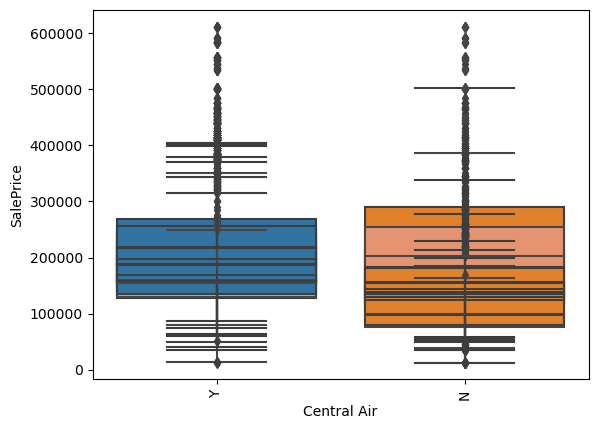

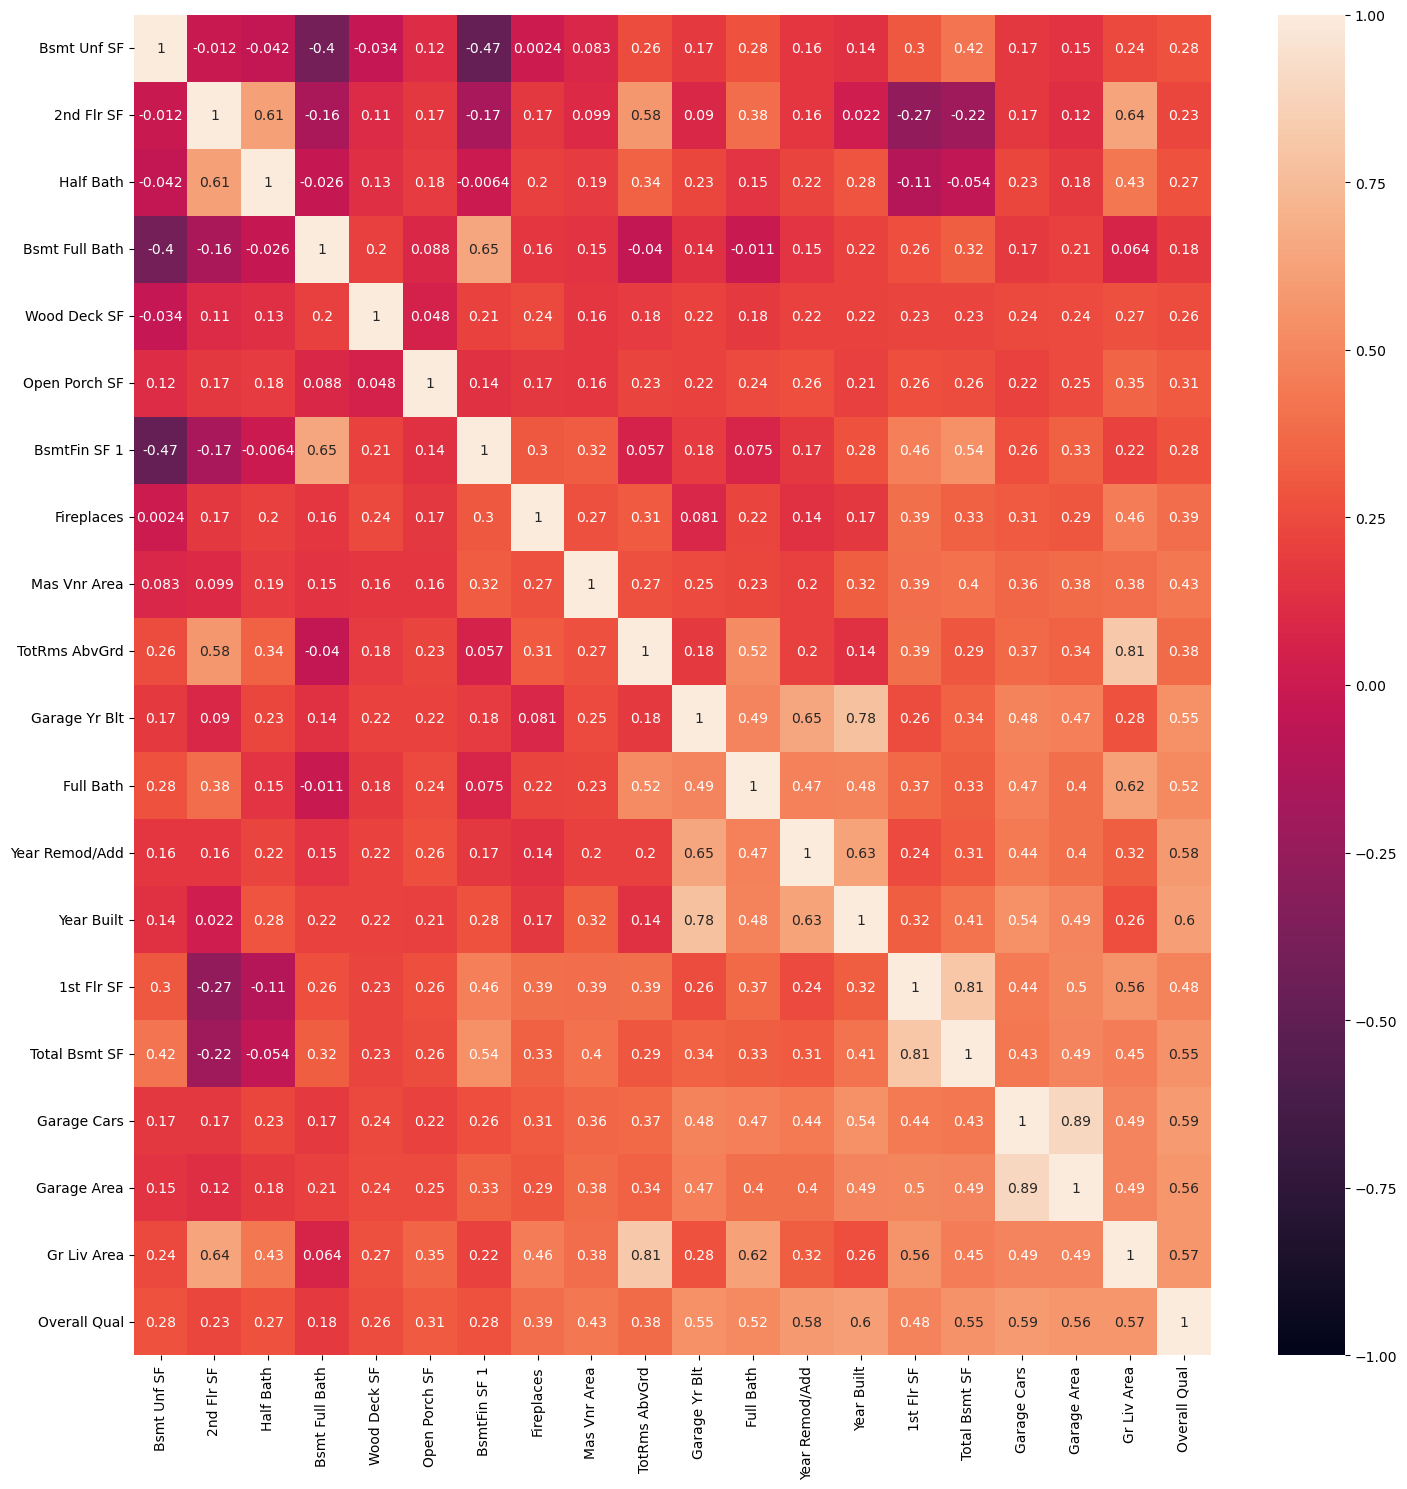

In [104]:
plt.figure(figsize= (15,15))
sns.heatmap(df_1.corr(), annot=True, vmin = -1, vmax = 1);

plt.tight_layout()
plt.savefig('correlations.png')
plt.show()

#### Removing 'TotRms AbvGrd' and 'Garage Yr Blt' as highly correlated to Gr Liv Area and Yr Built

In [105]:
df_model6 = df_model5.drop(columns = ['TotRms AbvGrd', 'Garage Yr Blt'], axis = 1)

In [106]:
X = df_model6.drop(columns = 'SalePrice')
y = df_model6['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25)

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

lr = LinearRegression()

In [107]:
lr.fit(X_train, y_train)
predictions = lr.predict(X_train)
rmse = (mean_squared_error(y_train, predictions)**0.5)

print(f'Train score: {lr.score(X_train, y_train)}, Test score: {lr.score(X_test, y_test)}, RMSE: {rmse}')

Train score: 0.8740340057409598, Test score: 0.8800534563917226, RMSE: 28225.422557918006


#### This resulted in a slight improvement in our model

#### Now let's removing outliers as these could be having an impact on our model, especially as larger houses may have more variable features which might not correlate as well to sale price at higher values.

In [108]:
#Starting with the continuous variables we've kept
df_model6_cont = df[['Half Bath', 'Bsmt Full Bath',   'Wood Deck SF',   'BsmtFin SF 1',
           'Fireplaces',   'Mas Vnr Area',  'TotRms AbvGrd',  'Garage Yr Blt',
            'Full Bath', 'Year Remod/Add',     'Year Built',  'Total Bsmt SF',
          'Garage Cars',    'Garage Area',    'Gr Liv Area',   'Overall Qual']]

In [109]:
df_model6_cont

,Half Bath,Bsmt Full Bath,Wood Deck SF,BsmtFin SF 1,Fireplaces,Mas Vnr Area,TotRms AbvGrd,Garage Yr Blt,Full Bath,Year Remod/Add,Year Built,Total Bsmt SF,Garage Cars,Garage Area,Gr Liv Area,Overall Qual
0,1,0.0,0,533.0,0,289.0,6,1976.0,2,2005,1976,725.0,2.0,475.0,1479,6
1,1,1.0,0,637.0,1,132.0,8,1997.0,2,1997,1996,913.0,2.0,559.0,2122,7
2,0,1.0,0,731.0,0,0.0,5,1953.0,1,2007,1953,1057.0,1.0,246.0,1057,5
3,1,0.0,100,0.0,0,0.0,7,2007.0,2,2007,2006,384.0,2.0,400.0,1444,5
4,0,0.0,0,0.0,0,0.0,6,1957.0,2,1993,1900,676.0,2.0,484.0,1445,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,0,1.0,0,1011.0,1,0.0,7,2007.0,2,2007,2007,1884.0,2.0,520.0,1728,8
2047,0,0.0,158,262.0,0,0.0,4,1961.0,1,1950,1940,861.0,2.0,539.0,861,4
2048,1,0.0,0,0.0,1,0.0,9,1929.0,1,1950,1928,896.0,2.0,342.0,1913,6
2049,0,1.0,0,155.0,2,0.0,6,1956.0,1,1956,1956,1200.0,1.0,294.0,1200,4


In [110]:
df_model6_cont.hist(figsize = (15, 15));

In [111]:
sns.histplot(df_model6_cont['Gr Liv Area'], bins = 100)

<AxesSubplot:title={'center':'Overall Qual'}, xlabel='Gr Liv Area', ylabel='Count'>

In [112]:
sns.histplot(df_model6_cont['Total Bsmt SF'], bins = 100)

<AxesSubplot:title={'center':'Overall Qual'}, xlabel='Gr Liv Area', ylabel='Count'>

In [113]:
sns.histplot(df_model6_cont['Wood Deck SF'], bins = 100)

<AxesSubplot:title={'center':'Overall Qual'}, xlabel='Gr Liv Area', ylabel='Count'>

#### We can see that outliers in Gr Liv Area are widely dispersed above 3000 sq ft, so cutting off there

In [114]:
plt.scatter(df['Gr Liv Area'], df['SalePrice'])

In [115]:
df_model7 = df_model6[df_model6['Gr Liv Area'] < 3000]

In [116]:
df_model7

,Half Bath,Bsmt Full Bath,Wood Deck SF,BsmtFin SF 1,Fireplaces,Mas Vnr Area,Full Bath,Year Remod/Add,Year Built,Total Bsmt SF,...,Stone_ext_1st,Stucco_ext_1st,VinylSd_ext_1st,Wd Sdng_ext_1st,WdShing_ext_1st,Fa_heat,Gd_heat,Po_heat,TA_heat,Central Air
0,1,0.0,0,533.0,0,289.0,2,2005,1976,725.0,...,0,0,0,0,0,0,0,0,0,1
1,1,1.0,0,637.0,1,132.0,2,1997,1996,913.0,...,0,0,1,0,0,0,0,0,0,1
2,0,1.0,0,731.0,0,0.0,1,2007,1953,1057.0,...,0,0,1,0,0,0,0,0,1,1
3,1,0.0,100,0.0,0,0.0,2,2007,2006,384.0,...,0,0,1,0,0,0,1,0,0,1
4,0,0.0,0,0.0,0,0.0,2,1993,1900,676.0,...,0,0,0,1,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,0,1.0,0,1011.0,1,0.0,2,2007,2007,1884.0,...,0,0,1,0,0,0,0,0,0,1
2047,0,0.0,158,262.0,0,0.0,1,1950,1940,861.0,...,0,0,1,0,0,0,0,0,0,1
2048,1,0.0,0,0.0,1,0.0,1,1950,1928,896.0,...,0,0,0,0,0,0,1,0,0,1
2049,0,1.0,0,155.0,2,0.0,1,1956,1956,1200.0,...,0,0,0,0,0,0,0,0,1,1


In [117]:
plt.scatter(df_model7['Gr Liv Area'], df_model7['SalePrice'])

In [118]:
X = df_model7.drop(columns = 'SalePrice')
y = df_model7['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123, test_size=0.25)

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

lr = LinearRegression()

In [120]:
lr.fit(X_train, y_train)
predictions = lr.predict(X_train)
rmse = (mean_squared_error(y_train, predictions)**0.5)
cross_val_score (lr, X_train, y_train, cv = 5).mean()

print(f'Train score: {lr.score(X_train, y_train)}, Test score: {lr.score(X_test, y_test)}, RMSE: {rmse}')

Train score: 0.9116767281489101, Test score: 0.9049554617925974, RMSE: 22824.95819539562


In [121]:
cross_val_score (lr, X_train, y_train, cv = 5).mean()

-2.3246807959156874e+18

This looks like an improved model so lets try Ridge and Lasso as well

In [122]:
# Using Ridge and Lasso on model7

X = df_model7.drop(columns = 'SalePrice')
y = df_model7['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123, test_size=0.25)

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)




In [123]:
ridge.fit(X_train, y_train)
predictions = ridge.predict(X_train)
rmse = (mean_squared_error(y_train, predictions)**0.5)

print(f'Train score: {ridge.score(X_train, y_train)}, Test score: {ridge.score(X_test, y_test)}, RMSE: {rmse}')

Train score: 0.9116726793340114, Test score: 0.9049600579131519, RMSE: 22825.48134727737


In [124]:
cross_val_score (ridge, X_train, y_train, cv = 5).mean()

0.8919344884635049

In [125]:
# Using Ridge and Lasso on model7

X = df_model7.drop(columns = 'SalePrice')
y = df_model7['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25)

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)


In [126]:
lasso.fit(X_train, y_train)
predictions = lasso.predict(X_train)
rmse = (mean_squared_error(y_train, predictions)**0.5)

print(f'Train score: {lasso.score(X_train, y_train)}, Test score: {lasso.score(X_test, y_test)}, RMSE: {rmse}')

Train score: 0.9126558490528475, Test score: 0.9023532335820462, RMSE: 22773.186806472033


In [127]:
cross_val_score (lasso, X_train, y_train, cv = 5).mean()

0.8942479595407489

In [ ]:
So our best test score is Lasso. Let's see how this performs on test data predictions vs actuals.

In [128]:
predictions_test = lasso.predict(X_test)

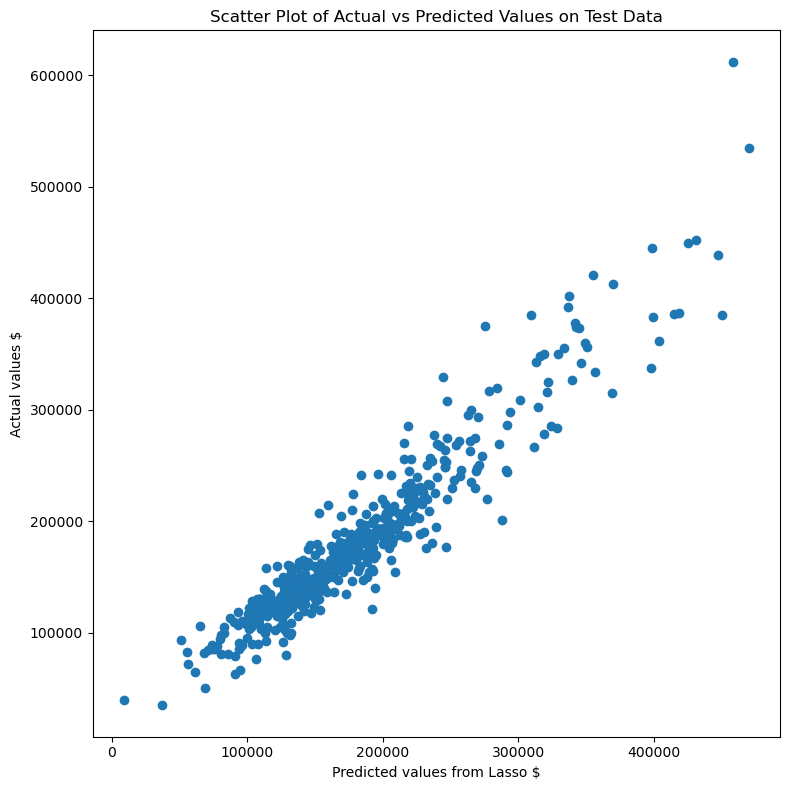

In [131]:
#Training set
plt.figure(figsize=(8,8))
plt.scatter(predictions_test, y_test)
plt.xlabel("Predicted values from Lasso $")
plt.ylabel("Actual values $")

plt.title('Scatter Plot of Actual vs Predicted Values on Test Data')

plt.tight_layout()
plt.savefig('predictions_lasso.png')

plt.show()


In [130]:
df_model7.to_csv('df_model7.csv')